# Queen's Gambit

In [1]:
! pip install deap

In [6]:
import random
import numpy as np
from deap import algorithms
from deap import base
from deap import creator
from deap import tools
from matplotlib import pyplot as plt
from matplotlib.pyplot import figure

In [3]:
BOARD_SIZE = 8
N_QUEENS = 8
SEED = 42

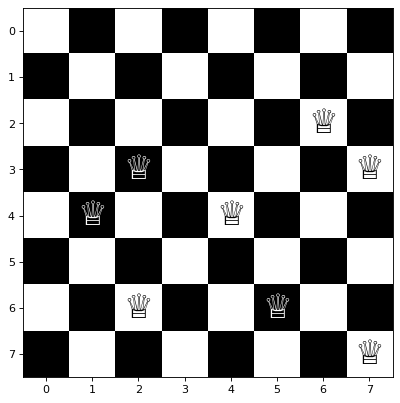

In [11]:
chess_board = np.zeros((BOARD_SIZE, BOARD_SIZE))

chess_board[1::2, 0::2] = 1
chess_board[0::2, 1::2] = 1

figure(figsize=(6, 6), dpi=80)
plt.imshow(chess_board, cmap='binary')

for _ in range(N_QUEENS):
    i, j = np.random.randint(0, BOARD_SIZE, 2)
    
    plt.text(i, j, 
             '♕',fontdict=dict(size=30), 
             ha='center', 
             va='center', 
             color='black' if (i - j) % 2 == 0 else 'white')
    
plt.show()

In [12]:
creator.create('FitnessMax',
               base.Fitness,
               weights=(-1.0,))

creator.create('Individual',
               list,
               fitness=creator.FitnessMax)

In [13]:
def eval_n_queens(individual):
    size = len(individual)
    
    left_diag = [0] * (2 * size - 1)
    right_diag = [0] * (2 * size - 1)
    
    for i in range(size):
        left_diag[i + individual[i]] += 1
        right_diag[size - 1 - i + individual[i]] += 1
        
    sum_ = 0
    
    for i in range(2 * size - 1):
        if left_diag[i] > 1:
            sum_ += left_diag[i] - 1
        
        if right_diag[i] > 1:
            sum_ += right_diag[i] - 1
        
    return sum_,

In [17]:
toolbox = base.Toolbox()

toolbox.register('permutation', random.sample, range(N_QUEENS), N_QUEENS)

toolbox.register('individual', tools.initIterate, creator.Individual, toolbox.permutation)

toolbox.register('population', tools.initRepeat, list, toolbox.individual)

toolbox.register('evaluate', eval_n_queens)
toolbox.register('mate', tools.cxPartialyMatched)
toolbox.register('mutate', tools.mutShuffleIndexes, indpb=2.0/N_QUEENS)
toolbox.register('select', tools.selTournament, tournsize=3)

In [18]:
def plot_board(individual):
    plt.imshow(chess_board, cmap='binary')
    
    for i in range(N_QUEENS):
        plt.text(i, individual[i], 
                 '♕',fontdict=dict(size=30), 
                 ha='center', 
                 va='center', 
                 color='black' if (i - individual[i]) % 2 == 0 else 'white')
    plt.show()

In [19]:
def ea_simple(population, toolbox, cx_pb, mut_pb, n_gen, max, stats=None, hall_of_fame=None):
    log_book = tools.Logbook()
    
    log_book.header = ['gen', 'nevals'] + \
        (stats.fields if stats else [])
        
    invalid_ind = [ind for ind in population if not ind.fitness.valid]
    
    fitness = toolbox.map(toolbox.evaluate, invalid_ind)
    
    for ind, fit in zip(invalid_ind, fitness):
        ind.fitness.values = fit
        
    if hall_of_fame is not None:
        hall_of_fame.update(population)
        
    record = stats.compile(population) if stats else {}
    
    log_book.record(gen=0, nevals=len(invalid_ind), **record)
    
    print(log_book.stream)
    
    done = False
    
    for gen in range(1, n_gen + 1):
        if done:
            return
        
        offspring = toolbox.select(population, len(population))
        
        offspring = [toolbox.clone(ind) for ind in offspring]
        
        for i in range(1, len(offspring), 2):
            if random.random() < cx_pb:
                offspring[i - 1], offspring[i] = toolbox.mate(offspring[i - 1], offspring[i])
                
                del offspring[i - 1].fitness.values, offspring[i].fitness.values
                
        for i in range(len(offspring)):
            if random.random() < mut_pb:
                offspring[i], = toolbox.mutate(offspring[i])
                del offspring[i].fitness.values
                
        invalid_ind = [ind for ind in offspring if not ind.fitness.valid]
        
        fitness = toolbox.map(toolbox.evaluate, invalid_ind)
        
        for ind, fit in zip(invalid_ind, fitness):
            ind.fitness.values = fit
            
            if fit[0] >= max:
                print('Solved')
                done = True
                
        if hall_of_fame is not None:
            hall_of_fame.update(offspring)
            plot_board(hall_of_fame[0])
            
        population[:] = offspring
        
        record = stats.compile(population) if stats else {}
        
        log_book.record(gen=gen, nevals=len(invalid_ind), **record)
        
        print(log_book.stream)

gen	nevals	Avg 	Std    	Min	Max
0  	100   	3.96	1.19097	1  	7  


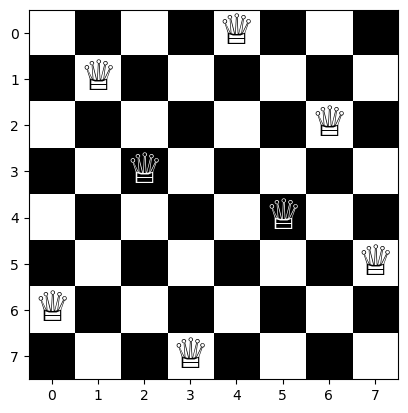

1  	50    	3.45	1.1694 	1  	7  
Solved
Solved


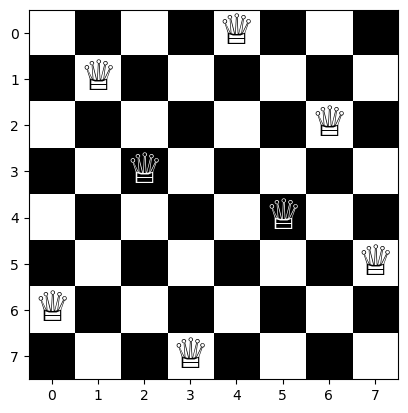

2  	54    	3.23	1.32556	1  	9  


In [20]:
random.seed(SEED)

pop = toolbox.population(n=100)

hof = tools.HallOfFame(1)

stats = tools.Statistics(lambda ind: ind.fitness.values)
stats.register('Avg', np.mean)
stats.register('Std', np.std)
stats.register('Min', np.min)
stats.register('Max', np.max)

ea_simple(pop, toolbox, cx_pb=.5, mut_pb=.2, n_gen=100, max=N_QUEENS, stats=stats, hall_of_fame=hof)